コスト出力のモデル作成

72size mapで追加特徴量

In [1]:
import time
import glob
import pickle
import numpy as np
import pandas as pd
from pandarallel import pandarallel
# from tqdm import tqdm

from ifloat.usecase.area_evaluator import SplittingGridEvaluator, WholeGridEvaluator, IAreaEvaluator
from ifloat.util.dependency import Dependency
from ifloat.infra.visualizer import visualize_floor, visualize_grid_and_sg

In [2]:
injector = Dependency()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
with open("../data_set/layout_set/9layout/layout_set.pkl", "rb") as f:
    _, area, routes = pickle.load(f)

routes = routes[:-1]

モデル作成

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from mlmodel.mk_model import make_deep_data


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


テストデータのかさまし

In [5]:
# train_datagen=ImageDataGenerator(
#                                 #  width_shift_range=1/72,
#                                 #  height_shift_range=1/72,
#                                  horizontal_flip=True,
#                                  vertical_flip=True
#                                 )       

In [6]:
valid_datagen=ImageDataGenerator(
                                #  width_shift_range=1/72,
                                #  height_shift_range=1/72,
                                #  horizontal_flip=True,
                                #  vertical_flip=True
                                ) 

マップの読み込み

72×72×23

In [7]:
# with open("data_set/training/72bit_map_data.pkl", "rb") as f:
#     map_data = pickle.load(f)
    
# print(len(map_data))

72,72,1

In [8]:
# with open("data_set/training/72bit_cost_only_m.pkl", "rb") as f:
#     only_map_data = pickle.load(f)

# only_map_data=np.expand_dims(only_map_data,axis=-1)    

# print(len(only_map_data))

ラベルの読み込み

In [9]:
# # 保存したラベルを読み込む
# with open("data_set/training_label/lock_sg_2/72bit_cost_labels.pkl", "rb") as f:
#     labels = pickle.load(f)



In [10]:
with open("../data_set/training/randam/9map_2/filter_each_conbine_astar_map.pkl", "rb") as f:
    only_map_data = pickle.load(f)



print(len(only_map_data))
with open("../data_set/training_label/randam/9map_2/notinf_cost_labels.pkl", "rb") as f:
    labels = pickle.load(f)

25430


In [11]:
# X_train = np.array(map_data)
X_train = np.array(only_map_data)



Y_train = np.array(labels)
Y_train=np.expand_dims(Y_train,axis=-1)

print(X_train.shape,Y_train.shape)

(25430, 18, 18, 3) (25430, 1)


In [12]:
print(Y_train[1])

[35]


In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler()
y_train_normalized = scaler.fit_transform(Y_train.reshape(-1, 1))

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train_normalized, test_size=0.1)

In [15]:
print(x_train.shape,x_valid.shape,y_train.shape,y_valid.shape)

(22887, 18, 18, 3) (2543, 18, 18, 3) (22887, 1) (2543, 1)


検証データのロード

In [16]:
# with open("data_set/valid/72bit_map_data.pkl", "rb") as f:
#     valid_in_deep_data= pickle.load(f)

In [17]:
# with open("data_set/valid/72bit_cost_only_m.pkl", "rb") as f:
#     valid_only_m= pickle.load(f)
    
# valid_only_m=np.expand_dims(valid_only_m,axis=-1)

In [18]:
# # X_valid=np.array(valid_in_deep_data)
# X_valid=np.array(valid_only_m)

# print(len(X_valid))

検証データのラベル

In [19]:
# with open("data_set/valid_label/lock_sg_2/72bit_cost_labels.pkl", "rb") as f:
#     valid_labels= pickle.load(f)

In [20]:

# valid_labels=np.array(valid_labels)
# valid_labels=np.expand_dims(valid_labels,axis=-1)
# print(valid_labels[0])

データセット

In [21]:
# train_generator= train_datagen.flow(
#     X_train,
#     Y_train,
#     batch_size=batch_size
# )

In [22]:
# valid_generator= valid_datagen.flow(
#     X_valid,
#     valid_labels,
#     batch_size=batch_size
# )

In [23]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Dropout,BatchNormalization

In [24]:
# 実際の入力データの形状を確認
print("X_train shape:", X_train.shape)

# 入力形状を実際のデータに合わせて定義
input_map = Input(shape=(18, 18, 3))


# モデルの構築
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_map)
# x = BatchNormalization()(x)

x = MaxPooling2D((2, 2), padding='same')(x)
# x = Dropout(0.15)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)

x = MaxPooling2D((2, 2), padding='same')(x)
# x = Dropout(0.15)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)

x = MaxPooling2D((2, 2), padding='same')(x)
# x = Dropout(0.15)(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# # x = BatchNormalization()(x)
# # x = Dropout(0.15)(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# # x = BatchNormalization()(x)
# # x = Dropout(0.15)(x)
# x = MaxPooling2D((2, 2), padding='same')(x)


x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1,activation="linear")(x)  # 回帰出力

model = models.Model(inputs=input_map, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])








X_train shape: (25430, 18, 18, 3)


In [25]:
# 中間層出力モデルの作成
# layer_names = ['input_layer', 'conv2d',  'max_pooling2d', 'conv2d_1' ,'max_pooling2d_1', 'dense_1']
# intermediate_outputs = [model.get_layer(name).output for name in layer_names]
# activation_model = models.Model(inputs=model.input, outputs=intermediate_outputs)

In [26]:
def get_intermediate_outputs(data):
    # データの形状を確認
    print("Input data shape:", data.shape)
    
    
    
    # 中間層の出力を取得
    activations = activation_model.predict(data)
    
    # 各層の出力を表示
    for name, activation in zip(layer_names, activations):
        print(f"\nLayer {name}:")
        print(f"Output shape: {activation.shape}")
        print(f"Output stats: min={np.min(activation):.3f}, max={np.max(activation):.3f}, "
              f"mean={np.mean(activation):.3f}, std={np.std(activation):.3f}")
    
    return activations

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 18, 18, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 18, 18, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,256,449 (12.42 MB)

 Trainable params: 3,256,449 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

モデルの作成とコンパイル

In [28]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
batch_size=32

In [30]:
history = model.fit(x_train,y_train, epochs=30, batch_size=batch_size,
                    validation_data=(x_valid,y_valid),
                    )

Epoch 1/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - loss: 0.0161 - mae: 0.0627 - val_loss: 6.4382e-04 - val_mae: 0.0170
Epoch 2/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - loss: 6.6228e-04 - mae: 0.0181 - val_loss: 7.3707e-04 - val_mae: 0.0215
Epoch 3/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - loss: 6.4722e-04 - mae: 0.0179 - val_loss: 3.9806e-04 - val_mae: 0.0130
Epoch 4/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - loss: 4.8339e-04 - mae: 0.0151 - val_loss: 8.6301e-04 - val_mae: 0.0212
Epoch 5/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 4.0567e-04 - mae: 0.0138 - val_loss: 7.2323e-04 - val_mae: 0.0229
Epoch 6/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - loss: 4.6068e-04 - mae: 0.0152 - val_loss: 3.7376e-04 - val_mae: 0.0122
Epoch 7/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - loss: 3.3336e-04 - mae: 0.0125 - val_loss: 3.4256e-04 - val_mae: 0.0112
Epoch 8/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - loss: 3.1271e-04 - mae: 0.0123 - val_loss: 4.1093e-0

損失関数のプロット

<function matplotlib.pyplot.show(close=None, block=None)>

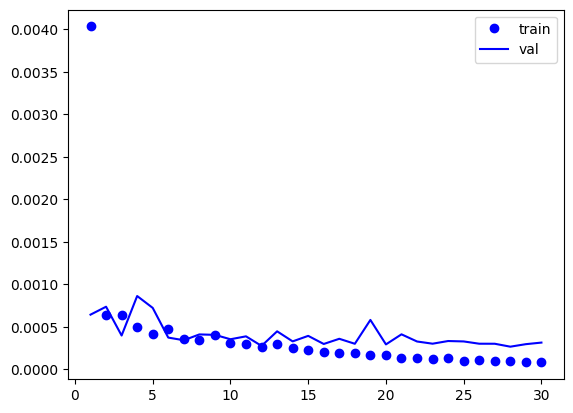

In [31]:
history_di= history.history
loss= history_di["loss"]
val= history_di["val_loss"]

epochs=range(1,len(loss)+1)

plt.plot(epochs,loss,"bo",label="train")
plt.plot(epochs,val,"b",label="val")
# plt.xlim(1,100)
# plt.ylim(50,20000)
plt.legend()
plt.show

テストデータのロード

In [32]:
# with open("data_set/test/72bit_map_data.pkl", "rb") as f:
#     test_in_deep_data= pickle.load(f)

In [33]:
# with open("data_set/test/72bit_cost_only_m.pkl", "rb") as f:
#     test_only_m= pickle.load(f)
    
# test_only_m=np.expand_dims(test_only_m,axis=-1)

In [34]:
with open("../data_set/test/randam/9map_2/filter_each_conbine_astar_map.pkl", "rb") as f:
    test_only_m = pickle.load(f)

In [35]:
# T=np.array(test_in_deep_data)
T=np.array(test_only_m)

print(T.shape)

(1922, 18, 18, 3)


In [36]:
# with open("data_set/test_label/lock_sg_2/72bit_cost_labels.pkl", "rb") as f:
#     test_labels= pickle.load(f)

In [37]:

with open("../data_set/test_label/randam/9map_2/notinf_cost_labels.pkl", "rb") as f:
    test_labels= pickle.load(f)

In [38]:
test_labels=np.array(test_labels)
test_labels=test_labels.reshape((len(test_labels),1))
# print(test_labels)
print((test_labels))

[[48]
 [47]
 [27]
 ...
 [38]
 [36]
 [20]]


予測

In [49]:
start_time = time.time()  # 予測開始時刻を記録
# pre_cost = model.predict(T)
y_pred_normalized = model.predict(T)

end_time = time.time()  # 予測終了時刻を記録
pre_cost = scaler.inverse_transform(y_pred_normalized)
elapsed_time = end_time - start_time

print(pre_cost.shape)
print(elapsed_time)



61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
(1922, 1)
0.6070818901062012


In [40]:
for i in range(len(test_labels)):
    print(test_labels[i],pre_cost[i])


[48] [47.01493]
[47] [47.26842]
[27] [28.606804]
[29] [30.00059]
[66] [65.49516]
[46] [46.303837]
[32] [34.93948]
[30] [30.605444]
[45] [47.390747]
[28] [27.342508]
[29] [28.220562]
[31] [30.941107]
[23] [23.457998]
[28] [28.49784]
[39] [39.494644]
[26] [26.609255]
[23] [22.883673]
[26] [26.391888]
[23] [23.413815]
[24] [22.872282]
[11] [11.782398]
[30] [28.749807]
[35] [35.01968]
[21] [21.3587]
[23] [23.416107]
[26] [26.968975]
[38] [38.62774]
[58] [59.462902]
[46] [43.237274]
[38] [39.379307]
[37] [37.910526]
[51] [48.053276]
[38] [39.115]
[45] [42.457817]
[31] [32.412106]
[33] [34.69739]
[32] [32.8585]
[32] [32.47555]
[31] [31.383015]
[25] [26.572548]
[30] [31.554567]
[41] [42.659233]
[42] [41.744377]
[42] [44.999825]
[26] [25.813421]
[29] [30.326143]
[56] [56.713432]
[35] [35.71254]
[26] [24.514765]
[26] [27.017303]
[33] [33.54553]
[24] [25.220715]
[41] [41.865067]
[21] [21.38712]
[46] [47.74426]
[32] [32.128582]
[20] [21.018692]
[25] [24.800339]
[47] [48.686234]
[29] [28.209858]
[

In [41]:
max_cost=max(pre_cost)
max_index=np.where(pre_cost==max_cost)

min_cost=min(pre_cost)
min_index=np.where(pre_cost==min_cost)

print(f"予測時間: {elapsed_time:.4f}秒")
# print(pre_cost)
print(max_cost,max_index)
print(min_cost,min_index)

print(pre_cost.shape)

予測時間: 0.7432秒
[79.471756] (array([1702], dtype=int64), array([0], dtype=int64))
[8.876489] (array([1847], dtype=int64), array([0], dtype=int64))
(1922, 1)


In [42]:
from mlmodel.mk_model import separate_m_start_goal

In [43]:


# print(test_labels)

#テストマップ最大最小の実コストのラベル
max_label=max(test_labels)
max_label_index=np.where(test_labels==max_label)

min_label=min(test_labels)
min_label_index=np.where(test_labels==min_label)
print(f"実際の最小コストマップ\n")
print(len(min_label_index))
#実際の最小コストマップ
# #
# m,starts,goals =separate_m_start_goal(T[min_label_index[0]][0])

print(min_label_index[0][0])
m=T[min_label_index[0][0]]
m=m.reshape((72,72))
starts=[[0,0],[71,71]]
goals=[[71,71],[0,0]]
    
visualize_grid_and_sg(m, starts, goals, size_inch=5.0)


print("テストマップの最大コストと最小コスト")
print(max_label,max_label_index[0][0])
print(min_label,min_label_index[0][0])
print("\n")

実際の最小コストマップ

2
1250


ValueError: cannot reshape array of size 972 into shape (72,72)

In [ ]:



print(f"モデルの予測した最大コストマップのコスト{max_cost}")
print(f"モデルの予測した最小コストマップのコスト{min_cost}\n")

print(f"モデルの予測した最小コストマップ\n")
#予測された最小コストマップ
# m,starts,goals =separate_m_start_goal(T[min_index[0]][0])
print(min_index[0][0])
m=T[min_index[0][0]].reshape((72,72))
starts=[[35,0],[35,71]]
goals=[[35,71],[35,0]]
    
visualize_grid_and_sg(m, starts, goals, size_inch=5.0)

print(f"モデルの予測した最大コストマップの実コスト{test_labels[max_index]}")
print(f"モデルの予測した最小コストマップの実コスト{test_labels[min_index]}")



比較する

In [55]:
pre_cost=np.round(pre_cost)
y=pre_cost.reshape((len(pre_cost),1))

In [54]:
a= abs(y-test_labels)
# print(a)

In [56]:
max_dev=max(a)
print(max_dev)

mean = sum(a)/len(a)
print(mean)

[10.]
[0.96201873]


In [47]:
with open(f"../data_set/test_label/randam/9map_2/astar/notinf_cost_labels.pkl","rb") as f:
    astar_cost=pickle.load(f)
    
z=np.array(astar_cost)
print(z.shape)
z=z.reshape((len(z),))


(1922,)


C:\Users\mochizuki\AppData\Local\Temp\ipykernel_32416\1301027628.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


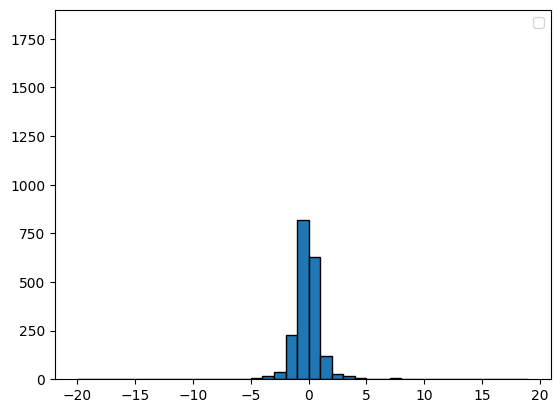

In [48]:
import numpy as np
import matplotlib.pyplot as plt

pre_cost=np.round(pre_cost)
y=pre_cost.reshape((len(pre_cost),))  # Adjust the length of x to match y
x = test_labels.reshape((len(test_labels),))

# d=np.array(pre_cost)
# d=d.reshape((549,))

w=x+z #real cost
#precost
A=(w-z-y)
# plt.scatter(x,A)
# plt.scatter(w,A)
# plt.scatter(w,x)
# plt.scatter(w, y+z,label="proposed method")
# plt.scatter(w,z,color="orange",label="astar cost")
# plt.xlabel('real cost - A*cost')  # 必要に応じてラベルを追加
# plt.ylabel('real cost - predict cost')
bins=np.arange(-20, 20, 1)
# plt.hist(x-z, bins="auto", edgecolor='black')
plt.hist(A, bins=bins, edgecolor='black')

plt.ylim(0,1900)
# fig, ax = plt.subplots()

# step4 箱ひげ図の描画
# 一般的な箱ひげ図
# ax.boxplot([x,A])


# y=xの直線を追加
# plt.plot(w, w, color='red', label='y=x')

# plt.plot(x, x, color='red', label='y=x')

# plt.plot(x, x+10, color='red', label='y=x')
# plt.plot(x, x-10, color='red', label='y=x')


plt.legend()
plt.show()

In [ ]:
model.save("../data_set/model/more_inf_linear_9map.keras")

In [ ]:
# 使用例
# X_trainの最初の1枚だけを使用してテスト
sample_data = T[0:1]  # バッチサイズ1で取得
activations = get_intermediate_outputs(sample_data)

# 可視化関数
def visualize_layer_outputs(activations, layer_names):
    
    for activation, name in zip(activations, layer_names):
        if len(activation.shape) == 4:  # 畳み込み層の出力
            n_features = min(20, activation.shape[-1])
            print(n_features)
            plt.figure(figsize=(12, 8))
            for i in range(n_features):
                plt.subplot(5, 4, i + 1)
                plt.imshow(activation[0, :, :, i], cmap='viridis')
                plt.axis('off')
            plt.suptitle(f'Feature maps of {name} layer')
            plt.show()
        elif len(activation.shape) == 2:  # 全結合層の出力
            plt.figure(figsize=(8, 4))
            plt.hist(activation[0], bins=50)#histgram
            plt.title(f'Activation distribution of {name} layer')
            plt.xlabel('Activation value')
            plt.ylabel('Frequency')
            plt.show()

# 可視化の実行
visualize_layer_outputs(activations, layer_names)

In [ ]:
counter=0
co=0
c=0
zero=0

d=abs(y-x)
e=abs(x-z)

for i in range(len(y)):
    

    if d[i]<e[i]:
        counter=counter+1
    elif e[i]<d[i]:
        co=co+1
    
    elif e[i]==d[i]:
        if e[i]==0:
            zero=zero+1
        c=c+1
    
print(f"good,bad,equal")
print(counter,co,c,zero)



good,bad,equal
907 459 282 73


In [ ]:
count=0

for i in range(len(y)):
    if x[i]==y[i]:
        count=count+1

accuracy=count/len(y)

print(accuracy)

0.4875130072840791


In [ ]:

sum_A=sum(A)

sum_t=sum(e)

print(sum_A/1648,sum_t/1648)

0.45813106796116504 3.516990291262136


In [ ]:
counter=0
for pred,real in zip(pre_cost,test_labels):
    threshold=1
    
    diff=abs(pred-real)
    
    if diff < threshold:
        counter=counter+1
    else :
        print(diff)
        
print(counter)
true_rate=counter/549
print(true_rate)

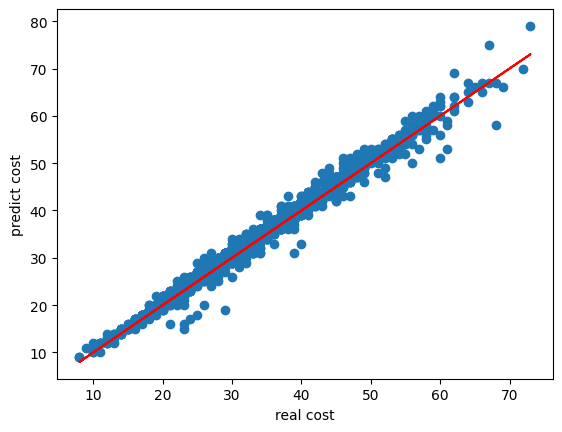

In [57]:


# y=pre_cost.reshape((549,))  # Adjust the length of x to match y
# x = test_labels.reshape((549,))

plt.scatter(x, y)
# plt.scatter(x,z,color="orange")
plt.xlabel('real cost')  # 必要に応じてラベルを追加
plt.ylabel('predict cost')

# y=xの直線を追加
plt.plot(x, x, color='red', label='y=x')

# plt.plot(x, x+10, color='red', label='y=x')
# plt.plot(x, x-10, color='red', label='y=x')



plt.show()